In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
from graph_tool.all import *
import os
import graph_tool.all as gt
import random
import statistics

In [2]:
def distance(coor1,coor2):
    long1 = coor1[0]; lat1 = coor1[1]
    long2 = coor2[0]; lat2 = coor2[1]
    if lat1==lat2 and long1==long2:
        return 0
    else:
        return (math.acos(math.sin(math.radians(lat1))*math.sin(math.radians(lat2))+\
                     math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.cos(math.radians(long2-long1)))*r)

In [3]:
def zenith_angle(sat, sta):
    lat = sta[1]/180*np.pi
    long = sta[0]/180*np.pi
    sat_lat = sat[1]/180*np.pi
    sat_long = sat[0]/180*np.pi
    z = np.sqrt(((h+r)*np.cos(sat_lat)*np.cos(sat_long)-r*np.cos(lat)*np.cos(long))**2 + \
                ((h+r)*np.cos(sat_lat)*np.sin(sat_long)-r*np.cos(lat)*np.sin(long))**2 + \
                ((h+r)*np.sin(sat_lat)-r*np.sin(lat))**2)
    cos_theta = (h**2-z**2+2*h*r)/(2*z*r)

In [4]:
def satellite_station_loss(sat, sta):
    lat = sta[1]/180*np.pi
    long = sta[0]/180*np.pi
    sat_lat = sat[1]/180*np.pi
    sat_long = sat[0]/180*np.pi
    z = np.sqrt(((h+r)*np.cos(sat_lat)*np.cos(sat_long)-r*np.cos(lat)*np.cos(long))**2 + \
                ((h+r)*np.cos(sat_lat)*np.sin(sat_long)-r*np.cos(lat)*np.sin(long))**2 + \
                ((h+r)*np.sin(sat_lat)-r*np.sin(lat))**2)
    # z = np.sqrt((r*np.cos(lat)*np.cos(long-sat)-h-r)**2 + (r*np.cos(lat)*np.sin(long-sat))**2 + (r*np.sin(lat))**2)
    wd = w0*np.sqrt(z**2/zR**2)
    eta_diffraction = 2*aR**2/wd**2
    cos_theta = (h**2-z**2+2*h*r)/(2*z*r)
    # cos_theta = ((h+r)**2-z**2+2*(h+r)*r)/(2*z*r)
    eta_atm = np.power(eta_atm0, 1/cos_theta)
    return eta_diffraction*eta_atm*0.5*0.5*0.9*0.9*0.7

In [5]:
with open('./census_data/coors.csv', 'r') as csvfile:
    coors = list(csv.reader(csvfile))[0]
    coors = [[float(item.strip('[').strip(']').split(',')[0]), float(item.strip('[').strip(']').split(',')[1])] for item in coors]
west_most = min([item[0] for item in coors])
east_most = max([item[0] for item in coors])
south_most = min([item[1] for item in coors])
north_most = max([item[1] for item in coors])

with open('./census_data/popu.csv', 'r') as csvfile:
    population = list(csv.reader(csvfile))[0]
    population = [int(item) for item in population]

w0 = 0.15; aR = 0.5; lamb = 8.1e-7
zR = np.pi*w0**2/lamb
h = 10000*1000
r = 6371*1000
eta_atm0 = 0.967
sat = [(west_most+east_most)/2, (south_most+north_most)/2]
print(sat)

g = load_graph('optical_fiber.gt.gz')
edge_distance = g.new_ep('double')
for e in g.edges():
    edge_distance[e] = distance(coors[int(e.source())], coors[int(e.target())])

[-95.82228375, 36.76971675]


In [6]:
with open('./alice_bob_pair.csv', 'r') as csvfile:
    Alice_bob_pairs = [[int(item) for item in item0] for item0 in list(csv.reader(csvfile))]
Alice_bob_distances = []
for item in Alice_bob_pairs:
    Alice_bob_distances.append(distance(coors[item[0]],coors[item[1]])/1e3)
with open('./alice_bob_path.csv', 'r') as csvfile:
    Alice_bob_paths = list(csv.reader(csvfile))
print(len(Alice_bob_pairs), len(Alice_bob_distances), len(Alice_bob_paths))

10000 10000 10000


In [33]:
sum(population)/len(population)

3957.006779293653

In [32]:
# with open('./alice_bob_distance.csv', 'w') as csvfile:
#     csv.writer(csvfile).writerow(Alice_bob_distances)

## Figure 2

In [33]:
def optimal_rate_repeater(l):
    rate_list = []
    for n in range(0,200):
        nu = np.log2(n+1)
        rate_list.append(1/((l/2**nu/c+T0)*np.power(3,nu)/np.power(2,nu-1)/np.power(P0,2)/np.power(10,-gamma*l/(n+1))))
    return max(rate_list), np.argmax(rate_list)

In [34]:
def rate_no_repeater(l):
    return 1/((2*l/c+T0)/(P0*np.power(10,-gamma*l)))

In [35]:
gamma = 0.0173; c = 2e5; T0 = 175e-6; P0 = 0.21;
optimal_rate = []; optimal_number_repeater = []
for l in range(1,1500):
    rate, num_repeater = optimal_rate_repeater(l)
    optimal_rate.append(rate); optimal_number_repeater.append(num_repeater)

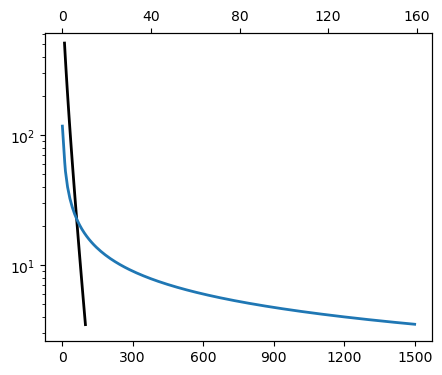

In [39]:
fig, ax1 = plt.subplots(figsize=(5,4))

ax2 = ax1.twiny()
ax2.plot(optimal_number_repeater, range(1,1500), color='white', linewidth=0)
ax2.tick_params(axis='x', labelcolor='black')
ax2.xaxis.set_ticks([0,40,80,120,160])

ax1.plot(range(10,100), [1/((2*item/c+T0)/(P0*np.power(10,-gamma*item))) for item in range(10,100)], color='black', linewidth=2)
ax1.plot(range(1,1500), optimal_rate, color='tab:blue', linewidth=2)
plt.yscale('log'); 
plt.ylim(2.6,6.1e2)
ax1.xaxis.set_ticks([0,300,600,900,1200,1500])
plt.savefig('/users/yanxuan/Desktop/2-1.png', dpi=300)
plt.show()

In [40]:
optimal_rate1 = []; optimal_number_repeater1 = []
for l in np.arange(1,120,0.1):
    rate_list = []
    for n in range(0,50):
        nu = np.log2(n+1)
        rate_list.append(1/((l/2**nu/c+T0)*np.power(3,nu)/np.power(2,nu-1)/np.power(P0,2)/np.power(10,-gamma*l/(n+1))))
    optimal_rate1.append(max(rate_list)); optimal_number_repeater1.append(np.argmax(rate_list))

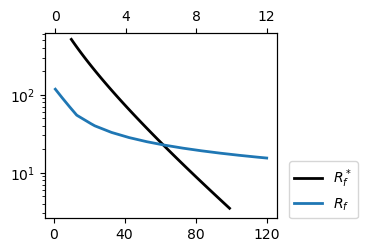

In [41]:
fig, ax1 = plt.subplots(figsize=(3,2.4))

ax2 = ax1.twiny()
ax2.plot(optimal_number_repeater1, np.arange(1,120,0.1), linewidth=0)
# ax2.tick_params(axis='x', labelcolor='black')
ax2.xaxis.set_ticks([0,4,8,12])

ax1.plot(range(10,100), [1/((2*item/c+T0)/(P0*np.power(10,-gamma*item))) for item in range(10,100)], color='black', linewidth=2, label='$R_f^*$')
ax1.plot(np.arange(1,120,0.1), optimal_rate1, color='tab:blue', linewidth=2, label='$R_f$')
plt.yscale('log'); 
plt.ylim(2.6,6.1e2)
ax1.xaxis.set_ticks([0,40,80,120])
ax1.legend(loc=(1.05,0))

plt.savefig('/users/yanxuan/Desktop/2-2.png', dpi=300, bbox_inches='tight')

In [42]:
T0 = 175e-6; P0 = 0.21; c = 2e5; gamma = 0.0173
l = 300
rate_300 = []
for n in range(0,26):
    nu = np.log2(n+1)
    rate_300.append(1/((l/2**nu/c+T0)*np.power(3,nu)/np.power(2,nu-1)/np.power(P0,2)/np.power(10,-gamma*l/(n+1))))
l = 200
rate_200 = []
for n in range(0,26):
    nu = np.log2(n+1)
    rate_200.append(1/((l/2**nu/c+T0)*np.power(3,nu)/np.power(2,nu-1)/np.power(P0,2)/np.power(10,-gamma*l/(n+1))))

In [46]:
F0 = 0.99; Fphoton = 0.99; Fswap = 0.99;
V = 2*Fphoton-1;
F0 = 1/2*(1+V*(1-2*F0)**2);
with open('./fidelity_num_repeaters.csv', 'r') as csvfile:
    repeater_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]
repeater_fidelity.insert(0,F0)

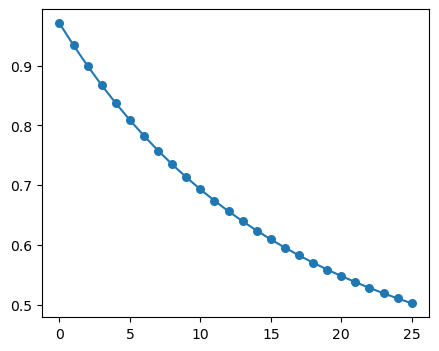

In [49]:
plt.figure(figsize=(5,4))
plt.scatter(range(26), repeater_fidelity, s=30)
plt.plot(range(26),repeater_fidelity)
plt.savefig('/users/yanxuan/Desktop/2-2.png', dpi=300, bbox_inches='tight')

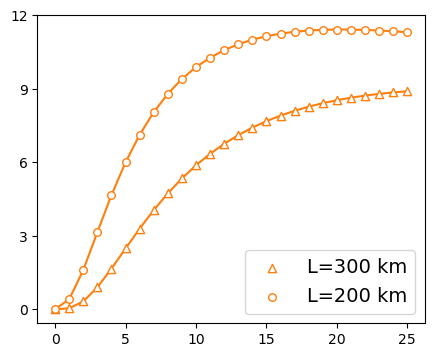

In [54]:
plt.figure(figsize=(5,4))
plt.plot(range(26), rate_300, color='tab:orange', zorder=1)
plt.scatter(range(26), rate_300, s=35, marker='^', facecolors='white', color='tab:orange', label='L=300 km', zorder=2)
plt.plot(range(26), rate_200, color='tab:orange', zorder=0)
plt.scatter(range(26), rate_200, s=30, facecolors='white', edgecolors='tab:orange', label='L=200 km', zorder=3)
plt.legend(fontsize=14)
plt.yticks([0,3,6,9,12])

plt.savefig('/users/yanxuan/Desktop/2-3.png', dpi=300, bbox_inches='tight')

## Figure 4

Figure 4(a) <br>
Entanglement distribution rate via satellite (one entanglement with fidelity 0.87)

In [11]:
# Sat_rate = [6e7*satellite_station_loss(sat, coors[item[0]])*satellite_station_loss(sat, coors[item[1]]) for item in Alice_bob_pairs]
# with open('./alice_bob_sat_rate.csv', 'w') as csvfile:
#     csv.writer(csvfile).writerow(Sat_rate)

In [19]:
with open('./alice_bob_sat_rate.csv', 'r') as csvfile:
    sat_rate = [float(item) for item in list(csv.reader(csvfile))[0]]
with open('./alice_bob_distance.csv', 'r') as csvfile:
    Alice_bob_distances = [float(item) for item in list(csv.reader(csvfile))[0]]

In [43]:
with open('./alice_bob_fiber_rate.csv', 'r') as csvfile:
    fiber_rate = [float(item) for item in list(csv.reader(csvfile))[0]]
fiber_rate = [item if item>1e-6 else 0 for item in fiber_rate]
print(len(fiber_rate))

10000


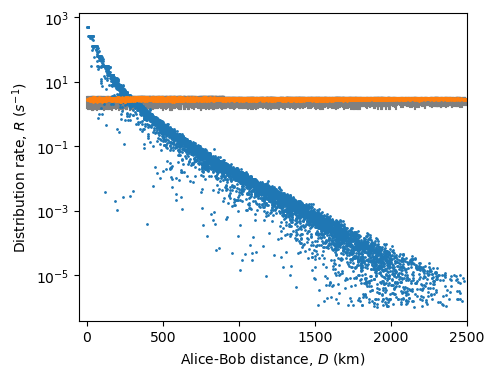

In [425]:
plt.figure(figsize=(5,4))
plt.scatter([Alice_bob_distances[i] for i in range(10000) if fiber_rate[i]>1e-6], [item for item in fiber_rate if item>1e-6], s=1, zorder=1); 
plt.scatter(Alice_bob_distances, sat_rate, s=1, zorder=2)
for i in range(2000):
    plt.plot([Alice_bob_distances[i],Alice_bob_distances[i]], [sat_rate_lower[i],sat_rate_upper[i]], color='grey',zorder=0)

plt.yscale('log'); plt.xlim(-50,2500)
plt.xlabel('Alice-Bob distance, $D$ (km)'); plt.ylabel('Distribution rate, $R$ ($s^{-1}$)')
plt.savefig('./4-1.png', dpi=300, bbox_inches='tight')

Figure 4(b) <br>
The fidelity via satellite is always 0.87 <br>
Use ./VK_matlab/fiber_fidelity_calculation.m to calculate the entanglement fidelity via fibers given the time needed for satellite (1/rate from Fig. 4(a))

10000


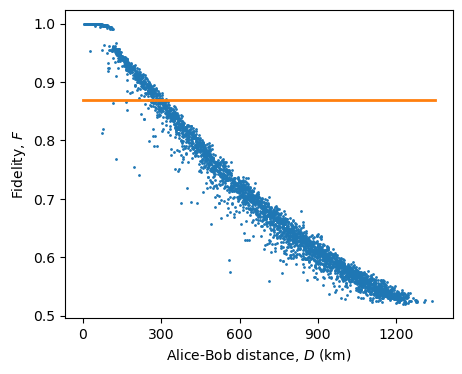

In [57]:
with open('./alice_bob_fiber_fidelity.csv', 'r') as csvfile:
    fiber_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]
print(len(fiber_fidelity))
plt.figure(figsize=(5,4))
plt.scatter([Alice_bob_distances[i] for i in range(10000) if fiber_fidelity[i]>0], [item for item in fiber_fidelity if item>0], s=1)
plt.plot([0,1350], [0.87,0.87], color='tab:orange', linewidth=2)
plt.xticks([0,300,600,900,1200]); 
plt.xlabel('Alice-Bob distance, $D$ (km)'); plt.ylabel('Fidelity, $F$')
plt.savefig('/Users/yanxuan/Desktop/4-2.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Fidelity, $F$')

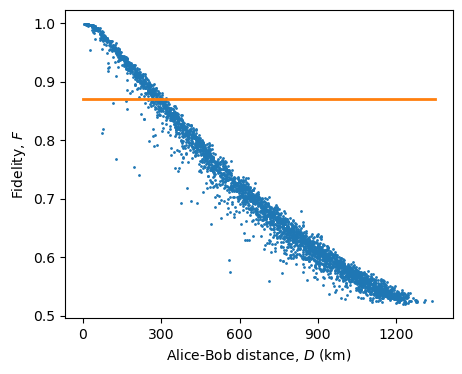

In [70]:
# old results
# with open('./alice_bob_fiber_fidelity.csv', 'r') as csvfile:
#     fiber_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]
# plt.figure(figsize=(5,4))
# plt.scatter([Alice_bob_distances[i] for i in range(10000) if fiber_fidelity[i]>0], [item for item in fiber_fidelity if item>0], s=1)
# plt.plot([0,1350], [0.87,0.87], color='tab:orange', linewidth=2)
# plt.xticks([0,300,600,900,1200]); 
# plt.xlabel('Alice-Bob distance, $D$ (km)'); plt.ylabel('Fidelity, $F$')
# # plt.savefig('/Users/yanxuan/Desktop/4-2.png', dpi=300, bbox_inches='tight')

Figure 4(c) <br>
scatter of the entanglement distribution rate vs fidelity from Fig 4(a) and (b)

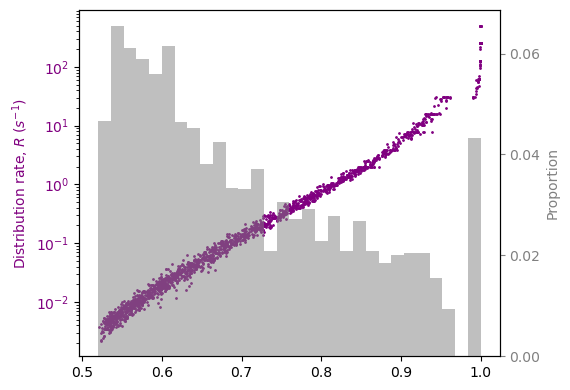

In [55]:
fig, ax1 = plt.subplots(figsize=(5.8,4))
ax1.scatter([item for item in fiber_fidelity[:5000] if item>0], \
            [fiber_rate[i] for i in range(5000) if fiber_fidelity[i]>0], s=1, color='purple')
plt.yscale('log'); plt.ylabel('Distribution rate, $R$ ($s^{-1}$)', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.yaxis.set_ticks([0,0.02,0.04,0.06]); 
ax2.set_ylabel('Proportion', color='grey')
ax2.tick_params(axis='y', colors='grey')
alice_bob_fiber_fidelity_mod = [item for item in fiber_fidelity if item>0]
ax2.hist(alice_bob_fiber_fidelity_mod, weights = [1/len(alice_bob_fiber_fidelity_mod) for item in alice_bob_fiber_fidelity_mod], bins=30, color='grey', alpha=0.5)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('/Users/yanxuan/Desktop/4-3.png', dpi=300, bbox_inches='tight')

## Figure 5

In [122]:
def find_closest_station(user, ground_indices):
    user_distance = [gt.shortest_distance(g, user, item, weights=edge_distance) for item in ground_indices]
    return ground_indices[np.argmin(user_distance)]

In [128]:
with open('./station_coors_700.csv', 'r') as csvfile:
    ground_indices = [int(item) for item in list(csv.reader(csvfile))[0]]

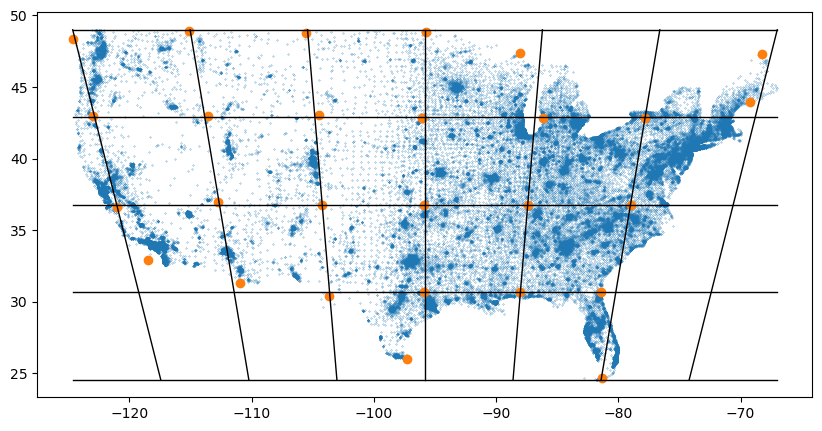

In [127]:
plt.figure(figsize=(10,5))
plt.scatter([item[0] for item in coors], [item[1] for item in coors], s=0.05)
            # [item/1e4 for item in population])
# , c=alice_station_dis_700)
# clb = plt.colorbar(); clb.set_label(label='Fiber length (km)',size=18); clb.ax.tick_params(labelsize=16) ; plt.set_cmap('viridis_r'); 
# plt.clim(0,1200)
plt.scatter([coors[item][0] for item in ground_indices], [coors[item][1] for item in ground_indices])

for i in range(5):
    y = south_most+(north_most-south_most)/4*i
    plt.plot([west_most, east_most], [y,y], color='black', linewidth=1)
for j in np.arange(-3,4,1):
    bottom = (west_most+east_most)/2+(east_most-west_most)/8*j
    top = (west_most+east_most)/2+(east_most-west_most)/6*j
    plt.plot([top, bottom], [north_most, south_most], color='black', linewidth=1)

## Figure 6 d-f

In [74]:
def find_closest_station(user, ground_indices):
    user_distance = [gt.shortest_distance(g, user, item, weights=edge_distance) for item in ground_indices]
    return ground_indices[np.argmin(user_distance)]

In [82]:
# with open('./MEO/station_700.csv', 'r') as csvfile:
#     ground_station_700 = [int(item) for item in list(csv.reader(csvfile))[0]]

# Alice_station_700 = []; Bob_station_700 = []
# for i in range(10000):
#     alice_bob = Alice_bob_pairs[i]
#     alice = alice_bob[0]; bob = alice_bob[1]
#     alice_station = find_closest_station(alice, ground_station_700)
#     bob_station = find_closest_station(bob, ground_station_700)
#     Alice_station_700.append(alice_station); 
#     Bob_station_700.append(bob_station)

# with open('./MEO/alice_station_700.csv', 'r') as csvfile:
#     alice_station_700 = [int(item) for item in list(csv.reader(csvfile))[0]]

# with open('./MEO/bob_station_700.csv', 'r') as csvfile:
#     bob_station_700 = [int(item) for item in list(csv.reader(csvfile))[0]]

In [86]:
# sat_rate_700 = []
# for i in range(10000):
#     alice_bob = Alice_bob_pairs[i]
#     alice = alice_bob[0]; bob = alice_bob[1]
#     sat_rate_700.append(6e7*satellite_station_loss(sat, coors[alice_station_700[i]])*satellite_station_loss(sat, coors[bob_station_700[i]]))
# with open('./MEO/sat_rate_700.csv', 'w') as csvfile:
#     csv.writer(csvfile).writerow(sat_rate_700)

In [89]:
# with open('./MEO/alice_station_450.csv', 'r') as csvfile:
#     alice_station_450 = [int(item) for item in list(csv.reader(csvfile))[0]]
# with open('./MEO/bob_station_450.csv', 'r') as csvfile:
#     bob_station_450 = [int(item) for item in list(csv.reader(csvfile))[0]]
    
# sat_rate_450 = []
# for i in range(10000):
#     alice_bob = Alice_bob_pairs[i]
#     alice = alice_bob[0]; bob = alice_bob[1]
#     sat_rate_450.append(6e7*satellite_station_loss(sat, coors[alice_station_450[i]])*satellite_station_loss(sat, coors[bob_station_450[i]]))
# with open('./MEO/sat_rate_450.csv', 'w') as csvfile:
#     csv.writer(csvfile).writerow(sat_rate_450)

In [90]:
# with open('./MEO/alice_station_240.csv', 'r') as csvfile:
#     alice_station_240 = [int(item) for item in list(csv.reader(csvfile))[0]]
# with open('./MEO/bob_station_240.csv', 'r') as csvfile:
#     bob_station_240 = [int(item) for item in list(csv.reader(csvfile))[0]]
    
# sat_rate_240 = []
# for i in range(10000):
#     alice_bob = Alice_bob_pairs[i]
#     alice = alice_bob[0]; bob = alice_bob[1]
#     sat_rate_240.append(6e7*satellite_station_loss(sat, coors[alice_station_240[i]])*satellite_station_loss(sat, coors[bob_station_240[i]]))
# with open('./MEO/sat_rate_240.csv', 'w') as csvfile:
#     csv.writer(csvfile).writerow(sat_rate_240)    

In [302]:
with open('./alice_bob_fiber_fidelity.csv', 'r') as csvfile:
    fiber_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]

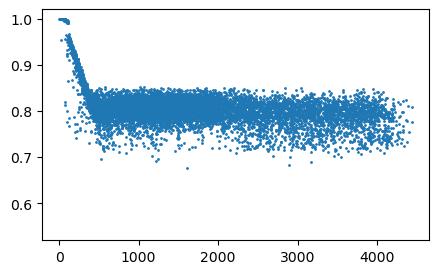

In [303]:
with open('./alice_bob_hybrid_fidelity_240.csv', 'r') as csvfile:
    hybrid_fidelity_240 = [float(item) for item in list(csv.reader(csvfile))[0]]
plt.figure(figsize=(5,3))
protocol_fidelity_240 = []
for i in range(10000):
    if hybrid_fidelity_240[i]>0:
        protocol_fidelity_240.append(max(fiber_fidelity[i],hybrid_fidelity_240[i]))
    else:
        protocol_fidelity_240.append(0)
plt.scatter([Alice_bob_distances[i] for i in range(10000) if protocol_fidelity_240[i]>0], [item for item in protocol_fidelity_240 if item>0.65], s=1)
plt.ylim(0.52,1.02)
plt.xticks([0,1000,2000,3000,4000]); plt.yticks([0.6,0.7,0.8,0.9,1])
plt.savefig('/Users/yanxuan/Desktop/6-6.png', dpi=300, bbox_inches="tight")
plt.show()

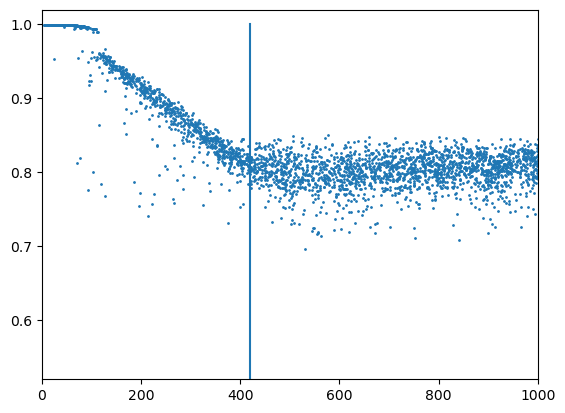

In [310]:
plt.scatter([Alice_bob_distances[i] for i in range(10000) if protocol_fidelity_240[i]>0], [item for item in protocol_fidelity_240 if item>0.65], s=1)
plt.ylim(0.52,1.02); plt.xlim(0,1000); plt.plot([420,420], [0.5,1])

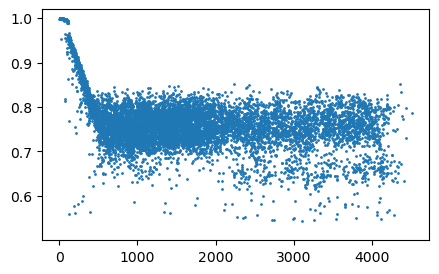

In [307]:
with open('./alice_bob_hybrid_fidelity_450.csv', 'r') as csvfile:
    hybrid_fidelity_450 = [float(item) for item in list(csv.reader(csvfile))[0]]
plt.figure(figsize=(5,3))
protocol_fidelity_450 = []
for i in range(10000):
    if hybrid_fidelity_450[i]>0:
        protocol_fidelity_450.append(max(fiber_fidelity[i],hybrid_fidelity_450[i]))
    else:
        protocol_fidelity_450.append(0)
plt.scatter([Alice_bob_distances[i] for i in range(10000) if protocol_fidelity_450[i]>0], [item for item in protocol_fidelity_450 if item>0], s=1)
plt.ylim(0.5,1.02)
plt.xticks([0,1000,2000,3000,4000]); plt.yticks([0.6,0.7,0.8,0.9,1])
plt.savefig('/Users/yanxuan/Desktop/6-5.png', dpi=300, bbox_inches="tight")
plt.show()

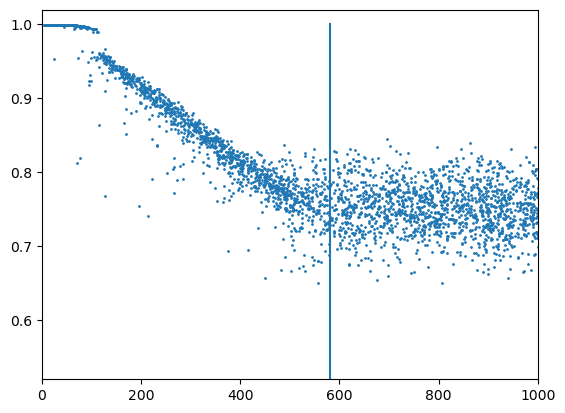

In [311]:
plt.scatter([Alice_bob_distances[i] for i in range(10000) if protocol_fidelity_450[i]>0.65], [item for item in protocol_fidelity_450 if item>0.65], s=1)
plt.ylim(0.52,1.02); plt.xlim(0,1000); plt.plot([580,580], [0.5,1])

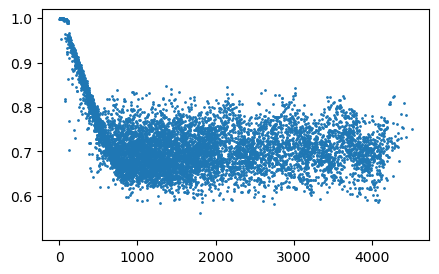

In [312]:
with open('./alice_bob_hybrid_fidelity_700.csv', 'r') as csvfile:
    hybrid_fidelity_700 = [float(item) for item in list(csv.reader(csvfile))[0]]
plt.figure(figsize=(5,3))
protocol_fidelity_700 = []
for i in range(10000):
    if hybrid_fidelity_700[i]>0:
        protocol_fidelity_700.append(max(fiber_fidelity[i],hybrid_fidelity_700[i]))
    else:
        protocol_fidelity_700.append(0)
plt.scatter([Alice_bob_distances[i] for i in range(10000) if protocol_fidelity_700[i]>0], [item for item in protocol_fidelity_700 if item>0], s=1)
plt.ylim(0.5,1.02)
plt.xticks([0,1000,2000,3000,4000]); plt.yticks([0.6,0.7,0.8,0.9,1])
plt.savefig('/Users/yanxuan/Desktop/6-4.png', dpi=300, bbox_inches="tight")
plt.show()

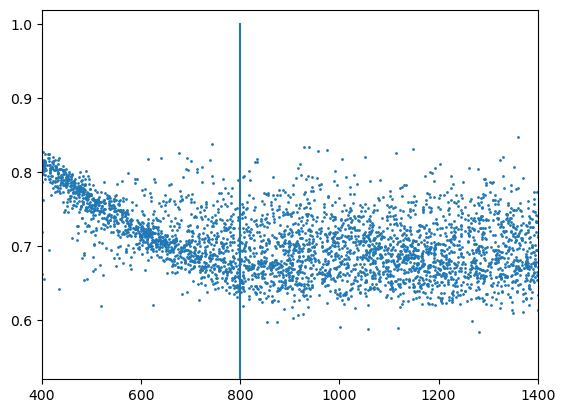

In [315]:
plt.scatter([Alice_bob_distances[i] for i in range(10000) if protocol_fidelity_700[i]>0.55], [item for item in protocol_fidelity_700 if item>0.55], s=1)
plt.ylim(0.52,1.02); plt.xlim(400,1400); plt.plot([800,800], [0.5,1])

0.804306278938902


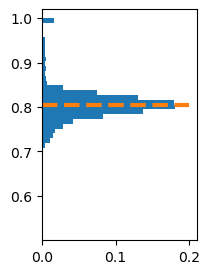

In [120]:
import statistics
med_240 = statistics.median([item for item in protocol_fidelity_240 if item>0]); print(med_240)
plt.figure(figsize=(2,3))
plt.hist([item for item in protocol_fidelity_240 if item>0], \
         weights=[1/len([item for item in protocol_fidelity_240 if item>0]) for item in [item for item in protocol_fidelity_240 if item>0]],\
         bins=30, range = (min([item for item in protocol_fidelity_240 if item>0]),1), orientation="horizontal")
plt.plot([0,0.2], [med_240,med_240], '--', linewidth=3)
plt.ylim(0.5,1.02); 
plt.yticks([0.6,0.7,0.8,0.9,1.0]); plt.xticks([0,0.1,0.2])
plt.savefig('/Users/yanxuan/Desktop/6-9.png', dpi=300, bbox_inches="tight")
plt.show()

0.761817323190358


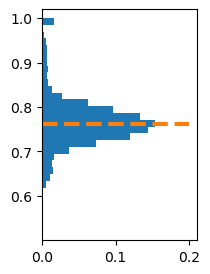

In [121]:
med_450 = statistics.median([item for item in protocol_fidelity_450 if item>0]); print(med_450)
plt.figure(figsize=(2,3))
plt.hist([item for item in protocol_fidelity_450 if item>0], \
         weights=[1/len([item for item in protocol_fidelity_450 if item>0]) for item in [item for item in protocol_fidelity_450 if item>0]],\
         bins=30, range = (min([item for item in protocol_fidelity_450 if item>0]),1), orientation="horizontal")
plt.plot([0,0.2], [med_450,med_450], '--', linewidth=3)
plt.ylim(0.5,1.02)
plt.yticks([0.6,0.7,0.8,0.9,1.0]); plt.xticks([0,0.1,0.2])
plt.savefig('/Users/yanxuan/Desktop/6-8.png', dpi=300, bbox_inches="tight")
plt.show()

0.70699007163813


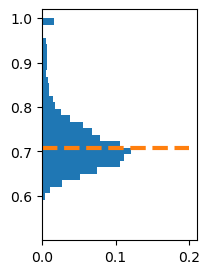

In [122]:
med_700 = statistics.median([item for item in protocol_fidelity_700 if item>0]); print(med_700)
plt.figure(figsize=(2,3))
plt.hist([item for item in protocol_fidelity_700 if item>0], \
         weights=[1/len([item for item in protocol_fidelity_700 if item>0]) for item in [item for item in protocol_fidelity_700 if item>0]],\
         bins=30, range = (min([item for item in protocol_fidelity_700 if item>0]),1), orientation="horizontal")
plt.plot([0,0.2], [med_700,med_700], '--', linewidth=3)
plt.ylim(0.5,1.02)
plt.yticks([0.6,0.7,0.8,0.9,1.0]); plt.xticks([0,0.1,0.2])
plt.savefig('/Users/yanxuan/Desktop/6-7.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# for i in range(10000):
#     alice_bob = alice_bob_pairs[i]
#     alice = alice_bob[0]; bob = alice_bob[1]
#     vlist, elist = gt.shortest_path(g, alice, Alice_station_700[i], weights=edge_distance)
#     path = [int(str(v)) for v in vlist]
#     alice_station_path = [distance(coors[path[i]],coors[path[i+1]])/1e3 for i in range(len(path)-1)]
#     vlist, elist = gt.shortest_path(g, bob, Bob_station_700[i], weights=edge_distance)
#     path = [int(str(v)) for v in vlist]
#     bob_station_path = [distance(coors[path[i]],coors[path[i+1]])/1e3 for i in range(len(path)-1)]
#     if len(alice_station_path) == 0:
#         alice_station_path = ['empty']
#     if len(bob_station_path) == 0:
#         bob_station_path = ['empty']
    # with open('./alice_station_path_700.csv', 'a') as csvfile:
    #     csv.writer(csvfile).writerow(alice_station_path)
    # with open('./bob_station_path_700.csv', 'a') as csvfile:
    #     csv.writer(csvfile).writerow(bob_station_path)

## Figure 6 g-i

In [167]:
with open('./alice_bob_fiber_rate.csv', 'r') as csvfile:
    fiber_rate = [float(item) for item in list(csv.reader(csvfile))[0]]
with open('./alice_bob_distance.csv', 'r') as csvfile:
    Alice_bob_distances = [float(item) for item in list(csv.reader(csvfile))[0]]

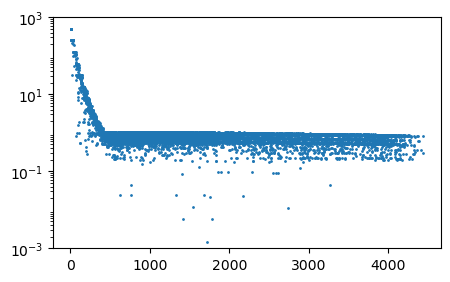

In [171]:
with open('./MEO/hybrid_240_time.csv', 'r') as csvfile:
    hybrid_rate_240 = [1/float(item) for item in list(csv.reader(csvfile))[0]]

plt.figure(figsize=(5,3))
protocol_rate_240 = []
for i in range((len(hybrid_rate_240))):
    if hybrid_rate_240[i]>1e-3:
        protocol_rate_240.append(max(fiber_rate[i],hybrid_rate_240[i]))
    else:
        protocol_rate_240.append(0)
plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_240)) if protocol_rate_240[i]>0], \
            [item for item in protocol_rate_240 if item>0], s=1)
plt.ylim(1e-3,1e3); plt.yscale('log')
plt.xticks([0,1000,2000,3000,4000]); plt.yticks([1e-3,1e-1,1e1,1e3])
plt.savefig('/Users/yanxuan/Desktop/6-12.png', dpi=300, bbox_inches="tight")
plt.show()

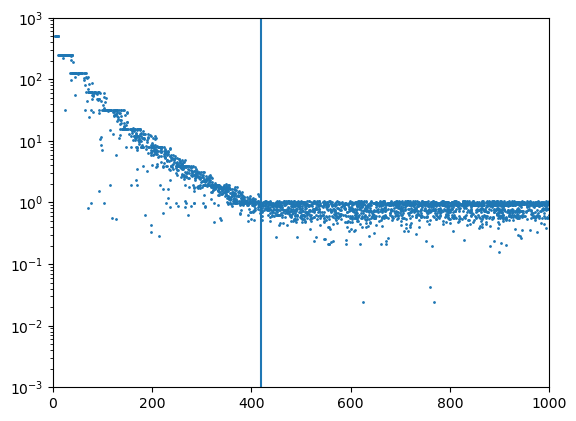

In [295]:
plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_240)) if protocol_rate_240[i]>0], \
            [item for item in protocol_rate_240 if item>0], s=1)
plt.ylim(1e-3,1e3); plt.xlim(0,1000); plt.plot([420,420], [1e-3,1e3])
plt.yscale('log')

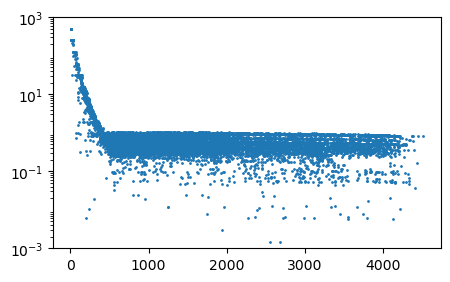

In [172]:
with open('./MEO/hybrid_450_time.csv', 'r') as csvfile:
    hybrid_rate_450 = [1/float(item) for item in list(csv.reader(csvfile))[0]]

plt.figure(figsize=(5,3))
protocol_rate_450 = []
for i in range((len(hybrid_rate_450))):
    if hybrid_rate_450[i]>1e-3:
        protocol_rate_450.append(max(fiber_rate[i],hybrid_rate_450[i]))
    else:
        protocol_rate_450.append(0)
plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_450)) if protocol_rate_450[i]>0], \
            [item for item in protocol_rate_450 if item>0], s=1)
plt.ylim(1e-3,1e3); plt.yscale('log')
plt.xticks([0,1000,2000,3000,4000]); plt.yticks([1e-3,1e-1,1e1,1e3])
plt.savefig('/Users/yanxuan/Desktop/6-11.png', dpi=300, bbox_inches="tight")
plt.show()

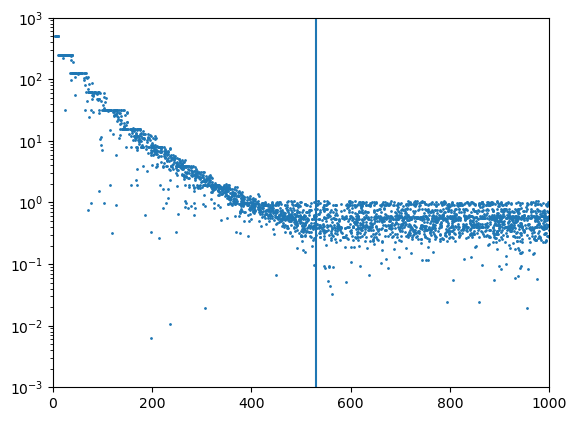

In [298]:
plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_450)) if protocol_rate_450[i]>0], \
            [item for item in protocol_rate_450 if item>0], s=1)
plt.ylim(1e-3,1e3); plt.xlim(0,1000); plt.plot([530,530], [1e-3,1e3])
plt.yscale('log')

9887


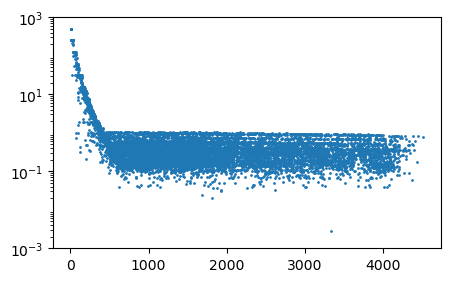

In [173]:
with open('./MEO/hybrid_700_time.csv', 'r') as csvfile:
    hybrid_rate_700 = [1/float(item) for item in list(csv.reader(csvfile))[0]]

print(len(hybrid_rate_700))

plt.figure(figsize=(5,3))
protocol_rate_700 = []
for i in range((len(hybrid_rate_700))):
    if hybrid_rate_700[i]>1e-3:
        protocol_rate_700.append(max(fiber_rate[i],hybrid_rate_700[i]))
    else:
        protocol_rate_700.append(0)
plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_700)) if protocol_rate_700[i]>0], \
            [item for item in protocol_rate_700 if item>0], s=1)
plt.ylim(1e-3,1e3); plt.yscale('log')
plt.xticks([0,1000,2000,3000,4000]); plt.yticks([1e-3,1e-1,1e1,1e3])
plt.savefig('/Users/yanxuan/Desktop/6-10.png', dpi=300, bbox_inches="tight")
plt.show()

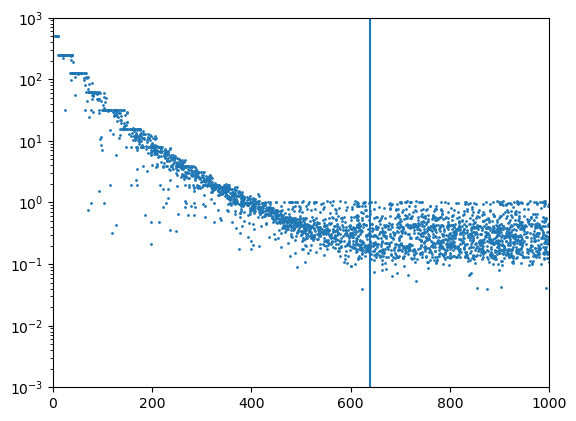

In [300]:
plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_700)) if protocol_rate_700[i]>0], \
            [item for item in protocol_rate_700 if item>0], s=1)
plt.ylim(1e-3,1e3); plt.xlim(0,1000); plt.plot([640,640], [1e-3,1e3])
plt.yscale('log')

0.8857276972927521


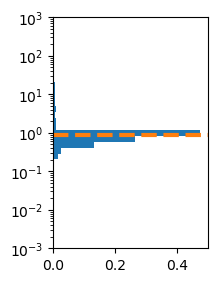

In [277]:
med_240_rate = statistics.median([item for item in protocol_rate_240 if item>0]); print(med_240_rate)
plt.figure(figsize=(2,3))
logbins = np.logspace(np.log10(1e-3),np.log10(1e3),40)
plt.hist([item for item in protocol_rate_240 if item>0], \
         weights=[1/len([item for item in protocol_rate_240 if item>0]) for item in [item for item in protocol_rate_240 if item>0]] , bins=logbins, range = (5e-5,1e3),\
         orientation="horizontal")
plt.ylim(1e-3,1e3); plt.xlim(0,0.5);plt.xticks([0,0.2,0.4])
plt.plot([0,0.5],[med_240_rate,med_240_rate],'--', linewidth=3)
plt.yscale('log')
plt.savefig('/Users/yanxuan/Desktop/6-15.png', dpi=300, bbox_inches="tight")
plt.show()

0.5615801847367228


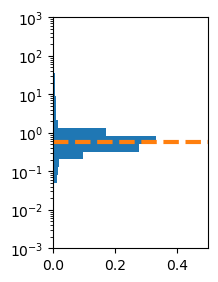

In [278]:
med_450_rate = statistics.median([item for item in protocol_rate_450 if item>0]); print(med_450_rate)
plt.figure(figsize=(2,3))
logbins = np.logspace(np.log10(1e-5),np.log10(1e3),40)
plt.hist([item for item in protocol_rate_450 if item>0], \
         weights=[1/len([item for item in protocol_rate_450 if item>0]) for item in [item for item in protocol_rate_450 if item>0]] , bins=logbins, range = (5e-5,1e3),\
         orientation="horizontal")
plt.ylim(1e-3,1e3); plt.xlim(0,0.5);plt.xticks([0,0.2,0.4])
plt.plot([0,0.5],[med_450_rate,med_450_rate],'--', linewidth=3)
plt.yscale('log')
plt.savefig('/Users/yanxuan/Desktop/6-14.png', dpi=300, bbox_inches="tight")
plt.show()

0.33294606489340345


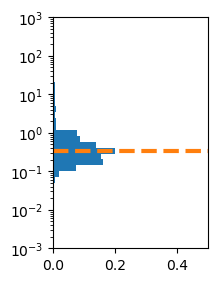

In [280]:
med_700_rate = statistics.median([item for item in protocol_rate_700 if item>0]); print(med_700_rate)
plt.figure(figsize=(2,3))
logbins = np.logspace(np.log10(1e-3),np.log10(1e3),40)
plt.hist([item for item in protocol_rate_700 if item>0], \
         weights=[1/len([item for item in protocol_rate_700 if item>0]) for item in [item for item in protocol_rate_700 if item>0]] , bins=logbins, range = (5e-5,1e3),\
         orientation="horizontal")
plt.ylim(1e-3,1e3); plt.xlim(0,0.5);plt.xticks([0,0.2,0.4])
plt.plot([0,0.5],[med_700_rate,med_700_rate],'--', linewidth=3)
plt.yscale('log')
plt.savefig('/Users/yanxuan/Desktop/6-13.png', dpi=300, bbox_inches="tight")
plt.show()

## Figure 7

Figure 7(a) <br>
Multiplies of data from Fig. 4(a)

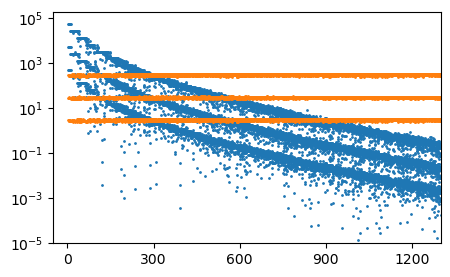

In [291]:
plt.figure(figsize=(5,3))
plt.scatter(Alice_bob_distances, fiber_rate, s=1, color='tab:blue')
plt.scatter(Alice_bob_distances, [10*item for item in fiber_rate], s=1, color='tab:blue')
plt.scatter(Alice_bob_distances, [100*item for item in fiber_rate], s=1, color='tab:blue')
plt.scatter(Alice_bob_distances, sat_rate, s=1, color='tab:orange'); 
plt.scatter(Alice_bob_distances, [item*10 for item in sat_rate], s=1, color='tab:orange')
plt.scatter(Alice_bob_distances, [item*100 for item in sat_rate], s=1, color='tab:orange')
plt.yscale('log')
plt.xlim(-50,1300); plt.ylim(1e-5,)
plt.xticks([0,300,600,900,1200])
plt.savefig('/Users/yanxuan/Desktop/7-1.png', dpi=300, bbox_inches='tight');plt.show()

In [10]:
# initial_fidelity = [0.87,0.86,0.85,0.84,0.83,0.82,0.81,0.8,0.79,0.78,0.77,0.76,0.75,0.74,0.73,0.72,0.71,0.7,0.69,0.68,0.67,0.66,\
#                     0.65,0.64,0.63,0.62,0.61,0.6,0.59,0.58,0.57,0.56,0.55,0.54,0.53,0.52]
# time_needed0 = [1,3,3,4,5,6,8,10,13,17,23,30,41,56,77,110,149,222,315,452,700,1050,\
#                 1650,2600,4300,6700,12500,26000,50000,100000,200000,400000,900000,2000000,4500000,9500000]
# # plt.plot(initial_fidelity, time_needed0)
# # plt.yscale('log')

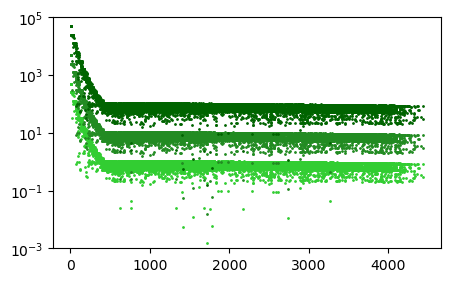

In [292]:
plt.figure(figsize=(5,3))
plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_240)) if protocol_rate_240[i]>0], \
            [item for item in protocol_rate_240 if item>0], s=1, color='limegreen')
plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_240)) if protocol_rate_240[i]>0], \
            [10*item for item in protocol_rate_240 if item>0], s=1, color='forestgreen')
plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_240)) if protocol_rate_240[i]>0], \
            [100*item for item in protocol_rate_240 if item>0], s=1, color='darkgreen')
plt.ylim(1e-3,1e5)
# plt.xticks([0,1000,2000,3000,4000]); plt.yticks([0.6,0.7,0.8,0.9,1])
plt.yscale('log')
plt.savefig('/Users/yanxuan/Desktop/7-2.png', dpi=300, bbox_inches="tight")
plt.show()

## Figure S1

In [46]:
h = 36000*1000
GEO_rate = [6e7*satellite_station_loss(sat, coors[item[0]])*satellite_station_loss(sat, coors[item[1]]) for item in Alice_bob_pairs]
with open('./GEO/sat_rate.csv', 'w') as csvfile:
    csv.writer(csvfile).writerow(GEO_rate)

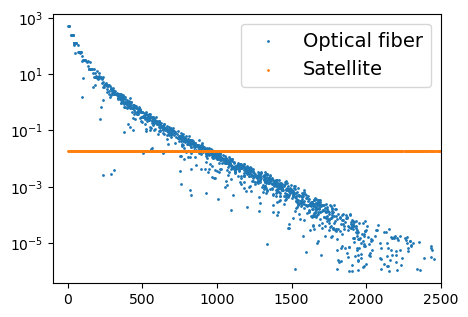

In [45]:
plt.figure(figsize=(5,3.5))
plt.scatter(Alice_bob_distances[:2000], fiber_rate[:2000],s=1, label='Optical fiber')
plt.scatter(Alice_bob_distances[:2000], GEO_rate[:2000],s=1, label='Satellite')
plt.legend(fontsize=14)
plt.xlim(-100, 2500)
plt.yscale('log')
plt.savefig('/Users/yanxuan/Desktop/s1-1', dpi=300, bbox_inches = 'tight')

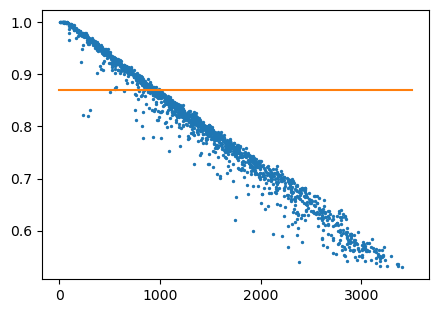

In [58]:
with open('./GEO/fiber_fidelity.csv', 'r') as csvfile:
    GEO_fiber_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]
plt.figure(figsize=(5,3.5))
plt.scatter([Alice_bob_distances[i] for i in range(2000) if GEO_fiber_fidelity[i]>0], [item for item in GEO_fiber_fidelity if item>0], s=2)
plt.plot([0,3500],[0.87,0.87], color='tab:orange'); plt.xticks([0,1000,2000,3000])
plt.savefig('/Users/yanxuan/Desktop/s1-2.png',dpi=300,bbox_inches='tight')

## Figure S2

In [104]:
# with open('./MEO/alice_station_240.csv', 'r') as csvfile:
#     alice_station_240 = [int(item) for item in list(csv.reader(csvfile))[0]]
# with open('./MEO/bob_station_240.csv', 'r') as csvfile:
#     bob_station_240 = [int(item) for item in list(csv.reader(csvfile))[0]]
with open('./GEO/fiber_fidelity.csv', 'r') as csvfile:
    GEO_fiber_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]
    
GEO_sat_rate_240 = []; h=36000*1e3
for i in range(2000):
    alice_bob = Alice_bob_pairs[i]
    alice = alice_bob[0]; bob = alice_bob[1]
    GEO_sat_rate_240.append(6e7*satellite_station_loss(sat, coors[alice_station_240[i]])*satellite_station_loss(sat, coors[bob_station_240[i]]))
with open('./GEO/sat_rate_240.csv', 'w') as csvfile:
    csv.writer(csvfile).writerow(GEO_sat_rate_240)  

In [69]:
with open('./GEO/hybrid_240_fidelity.csv', 'r') as csvfile:
    GEO_hybrid_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]
print(len(GEO_hybrid_fidelity))

2000


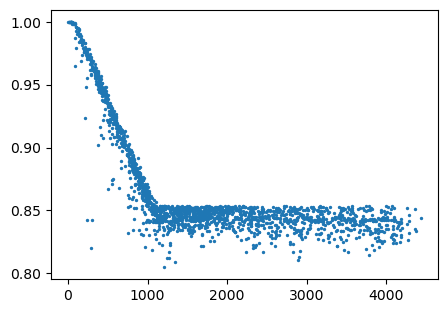

In [155]:
plt.figure(figsize=(5,3.5))
GEO_protocol_240 = [max(GEO_fiber_fidelity[i],GEO_hybrid_fidelity[i]) for i in range(2000)]
GEO_dis = [Alice_bob_distances[i] for i in range(2000) if GEO_protocol_240[i]>0.8]
GEO_protocol_240 = [item for item in GEO_protocol_240 if item>0.8]
plt.scatter(GEO_dis, GEO_protocol_240, s=2)
plt.yticks([0.8,0.85,0.9,0.95,1.0])
plt.savefig('/Users/yanxuan/Desktop/sup2-1.png',dpi=300,bbox_inches='tight')

In [105]:
# def purification_2_1(F1, F2):
#     p1 = (4*F1-1)/3; p2 = (4*F2-1)/3
#     p = (p1+p2+4*p1*p2)/(3+3*p1*p2)
#     prob = (1+p1*p2)/2
#     return (3*p+1)/4, prob
# def purification(F_list):
#     initial_F0 = F_list[0]
#     F_list = F_list[1:]
#     while len(F_list)>1:
#         F_list.sort(reverse=True)
#         newF, prob = purification_2_1(F_list[-2],F_list[-1])
#         F_list.pop(-1); F_list.pop(-1)
#         if np.random.random()<prob:
#             F_list.append(newF)
#     if len(F_list)>0:
#         F_list.sort(reverse=True)
#         return F_list[0]
#     else:
#         return initial_F0
# np.mean([purification([0.8 for i in range(10)]) for j in range(10000)])

In [160]:
initial_fidelity = [0.87,0.86,0.85,0.84,0.83,0.82,0.81,0.8]
time_needed0 = [1, 3, 3, 4, 5, 6, 8, 10]
GEO_protocol_240 = [max(GEO_fiber_fidelity[i],GEO_hybrid_fidelity[i]) for i in range(2000)]
GEO_protocol_rate = []; GEO_dis=[]
fidelity_threshold = 0.9
for i in range(2000):
    if GEO_hybrid_fidelity[i]>0.8:
        GEO_dis.append(Alice_bob_distances[i])
        item = 0
        if GEO_fiber_fidelity[i]>GEO_hybrid_fidelity[i]:
            if GEO_fiber_fidelity[i]>=0.87:
                GEO_protocol_rate.append(fiber_rate[i])
            else:
                item = GEO_fiber_fidelity[i]; rate0 = fiber_rate[i]
        else:
            item = GEO_hybrid_fidelity[i]; rate0 = GEO_sat_rate_240[i]
        if item!=0:
            item_b = np.floor(item*100)/100
            item_t = np.round((item_b+0.01)*100)/100
            time_b = time_needed0[initial_fidelity.index(item_b)]
            time_t = time_needed0[initial_fidelity.index(item_t)]
            time = np.log10(time_t)+(item-item_b)/0.01*(np.log10(time_b)-np.log10(time_t))
            time = np.power(10,time)
            GEO_protocol_rate.append(rate0/time)

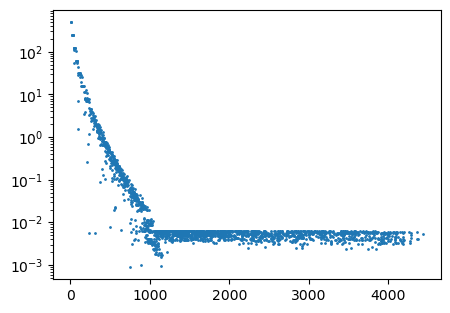

In [165]:
plt.figure(figsize=(5,3.5))
plt.scatter(GEO_dis, GEO_protocol_rate, s=1)
plt.yscale('log')
plt.savefig('/Users/yanxuan/Desktop/sup2-2.png', dpi=300,bbox_inches='tight')
plt.show()

In [226]:
len(GEO_fiber_fidelity)

2000

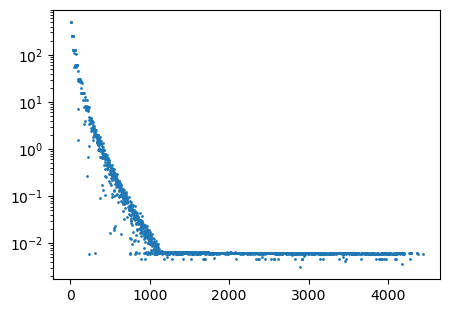

In [235]:
with open('./GEO/hybrid_240_time.csv', 'r') as csvfile:
    GEO_hybrid_rate_240 = [1/float(item) for item in list(csv.reader(csvfile))[0]]
with open('./alice_bob_fiber_rate.csv', 'r') as csvfile:
    fiber_rate = [float(item) for item in list(csv.reader(csvfile))[0]]
GEO_protocol_240 = []; GEO_protocol_dis = []
for i in range(2000):
    if GEO_hybrid_rate_240[i]>1e-5:
        GEO_protocol_dis.append(Alice_bob_distances[i])
        GEO_protocol_240.append(max(GEO_hybrid_rate_240[i],fiber_rate[i]))
# GEO_protocol_240 = [max(GEO_hybrid_rate_240[i],fiber_rate[i]) for i in range(2000)]
plt.figure(figsize=(5,3.5))
plt.scatter(GEO_protocol_dis, GEO_protocol_240, s=1)
plt.yscale('log');plt.savefig('/Users/yanxuan/Desktop/sup2-2.png', dpi=300,bbox_inches='tight')
plt.show()

## Figure S3

In [19]:
with open('./Fp_0.9/fiber_fidelity.csv', 'r') as csvfile:
    fiber_fidelity_Fp = [float(item) for item in list(csv.reader(csvfile))[0]]
with open('./alice_bob_fiber_fidelity.csv', 'r') as csvfile:
    fiber_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]
with open('./Fp_0.9/hybrid_fidelity_240.csv', 'r') as csvfile:
    hybrid_fidelity_Fp_240 = [float(item) for item in list(csv.reader(csvfile))[0]]

In [171]:
# plt.scatter(Alice_bob_distances[:2000], fiber_fidelity_Fp,s=1)
# plt.scatter(Alice_bob_distances, fiber_fidelity, s=1)

In [20]:
Fp_protocol_240 = []; Fp_240_dis = []; 
for i in range(2000):
    if hybrid_fidelity_Fp_240[i]>0.5:
        Fp_240_dis.append(Alice_bob_distances[i])
        if fiber_fidelity_Fp[i]>hybrid_fidelity_Fp_240[i]:
            Fp_protocol_240.append(fiber_fidelity_Fp[i])
        else:
            Fp_protocol_240.append(hybrid_fidelity_Fp_240[i])

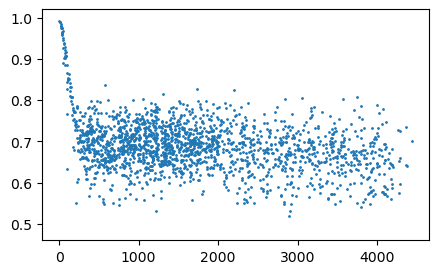

In [21]:
# plt.scatter(Alice_bob_distances[:2000], fiber_fidelity_Fp,s=1)
# plt.scatter(Alice_bob_distances[:2000], hybrid_fidelity_Fp_240, s=1)
plt.figure(figsize=(5,3))
plt.scatter(Fp_240_dis, Fp_protocol_240, s=1); plt.ylim(0.46,1.02);
plt.savefig('/Users/yanxuan/Desktop/s3-3.png', dpi=300, bbox_inches='tight')

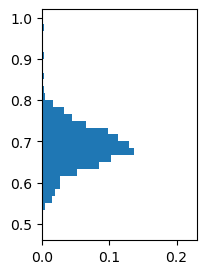

In [22]:
plt.figure(figsize=(2,3))
plt.hist(Fp_protocol_240, weights=[1/len(Fp_protocol_240) for item in Fp_protocol_240] , bins=30, range = (0.5,1),\
         orientation="horizontal")
# plt.xlabel('Fidelity', fontsize=18); plt.ylabel('Proportion', fontsize=18)
# plt.ylim(0.43,0.98); plt.xlim(0,0.33)
# plt.yticks([0.5,0.6,0.7,0.8,0.9], fontsize=16); plt.xticks([0,0.1,0.2,0.3], fontsize=16)
plt.ylim(0.46,1.02); plt.xlim(0,0.23)
plt.savefig('/Users/yanxuan/Desktop/s3-6.png', dpi=300, bbox_inches="tight")
plt.show()

In [23]:
with open('./Fp_0.9/hybrid_fidelity_450.csv', 'r') as csvfile:
    hybrid_fidelity_Fp_450 = [float(item) for item in list(csv.reader(csvfile))[0]]
Fp_protocol_450 = []; Fp_450_dis = []; 
for i in range(2000):
    if hybrid_fidelity_Fp_450[i]>0.4:
        Fp_450_dis.append(Alice_bob_distances[i])
        if fiber_fidelity_Fp[i]>hybrid_fidelity_Fp_450[i]:
            Fp_protocol_450.append(fiber_fidelity_Fp[i])
        else:
            Fp_protocol_450.append(hybrid_fidelity_Fp_450[i])

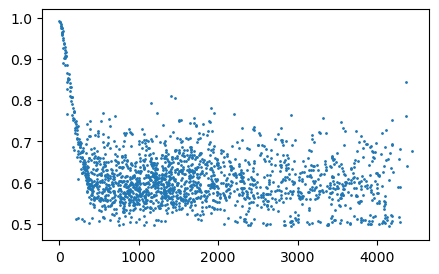

In [24]:
# plt.scatter(Alice_bob_distances[:2000], fiber_fidelity_Fp,s=1)
# plt.scatter(Alice_bob_distances[:2000], hybrid_fidelity_Fp_240, s=1)
plt.figure(figsize=(5,3))
plt.scatter(Fp_450_dis, Fp_protocol_450, s=1); plt.ylim(0.46,1.02);
plt.savefig('/Users/yanxuan/Desktop/s3-2.png', dpi=300, bbox_inches='tight')
# plt.ylim(0.43,0.98)

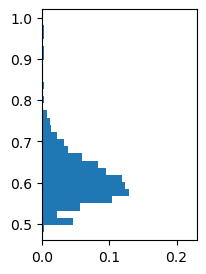

In [25]:
plt.figure(figsize=(2,3))
plt.hist(Fp_protocol_450, weights=[1/len(Fp_protocol_450) for item in Fp_protocol_450] , bins=30, range = (0.48,1),\
         orientation="horizontal")
plt.ylim(0.46,1.02); plt.xlim(0,0.23)
plt.savefig('/Users/yanxuan/Desktop/s3-5.png', dpi=300, bbox_inches="tight")
plt.show()

In [26]:
with open('./Fp_0.9/hybrid_fidelity_700.csv', 'r') as csvfile:
    hybrid_fidelity_Fp_700 = [float(item) for item in list(csv.reader(csvfile))[0]]
# plt.scatter(Alice_bob_distances[:2000], hybrid_fidelity_Fp_700, s=1)
Fp_protocol_700 = []; Fp_700_dis = []; 
for i in range(2000):
    if hybrid_fidelity_Fp_700[i]>0.4:
        Fp_700_dis.append(Alice_bob_distances[i])
        if fiber_fidelity_Fp[i]>hybrid_fidelity_Fp_700[i]:
            Fp_protocol_700.append(fiber_fidelity_Fp[i])
        else:
            Fp_protocol_700.append(hybrid_fidelity_Fp_700[i])

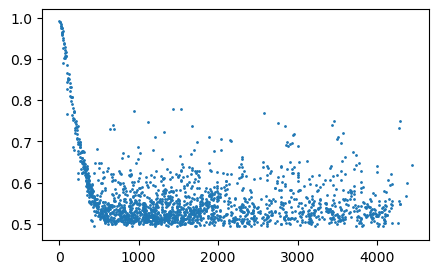

In [27]:
plt.figure(figsize=(5,3))
plt.scatter(Fp_700_dis, Fp_protocol_700, s=1); plt.ylim(0.46,1.02);
plt.savefig('/Users/yanxuan/Desktop/s3-1.png', dpi=300, bbox_inches='tight')
# plt.ylim(0.43,0.98)

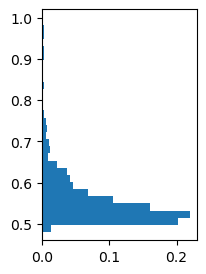

In [28]:
plt.figure(figsize=(2,3))
plt.hist(Fp_protocol_700, weights=[1/len(Fp_protocol_700) for item in Fp_protocol_700] , bins=30, range = (0.48,1),\
         orientation="horizontal")
plt.ylim(0.46,1.02); plt.xlim(0,0.23)
# plt.yticks([0.5,0.6,0.7,0.8,0.9], fontsize=16); plt.xticks([0,0.1,0.2,0.3], fontsize=16)
plt.savefig('/Users/yanxuan/Desktop/s3-4.png', dpi=300, bbox_inches="tight")
plt.show()

In [30]:
print(statistics.median(Fp_protocol_700), statistics.median(Fp_protocol_450), statistics.median(Fp_protocol_240))

0.538485109570982 0.602648090660918 0.687539623261361


## Figure S4 -- aR different values

In [35]:
with open('./alice_bob_fiber_rate.csv', 'r') as csvfile:
    fiber_rate = [float(item) for item in list(csv.reader(csvfile))[0]]
with open('./alice_bob_distance.csv', 'r') as csvfile:
    Alice_bob_distances = [float(item) for item in list(csv.reader(csvfile))[0]]

In [242]:
MEO_aR_1_rate = []; h=10000*1e3; aR = 1
for i in range(10000):
    alice_bob = Alice_bob_pairs[i]
    alice = alice_bob[0]; bob = alice_bob[1]
    MEO_aR_1_rate.append(6e7*satellite_station_loss(sat, coors[alice_station_240[i]])*satellite_station_loss(sat, coors[bob_station_240[i]]))
with open('./aR/aR_1_rate_240.csv', 'w') as csvfile:
    csv.writer(csvfile).writerow(MEO_aR_1_rate)  

In [243]:
MEO_aR_2_rate = []; h=10000*1e3; aR = 2
for i in range(10000):
    alice_bob = Alice_bob_pairs[i]
    alice = alice_bob[0]; bob = alice_bob[1]
    MEO_aR_2_rate.append(6e7*satellite_station_loss(sat, coors[alice_station_240[i]])*satellite_station_loss(sat, coors[bob_station_240[i]]))
with open('./aR/aR_2_rate_240.csv', 'w') as csvfile:
    csv.writer(csvfile).writerow(MEO_aR_2_rate)  

In [36]:
with open('./MEO/hybrid_240_time.csv', 'r') as csvfile:
    hybrid_rate_240 = [1/float(item) for item in list(csv.reader(csvfile))[0]]
aR_05_rate = []; aR_05_dis = []
# for i in range((len(hybrid_rate_240))):
for i in range(10000):
    if hybrid_rate_240[i]>1e-5:
        aR_05_rate.append(max(fiber_rate[i],hybrid_rate_240[i])); aR_05_dis.append(Alice_bob_distances[i])
    # else:
    #     aR_05_rate.append(0)
# plt.scatter([Alice_bob_distances[i] for i in range(len(protocol_rate_240)) if protocol_rate_240[i]>0], \
            # [item for item in protocol_rate_240 if item>0], s=1)
# plt.ylim(1e-3,1e3)
# plt.xticks([0,1000,2000,3000,4000]); plt.yticks([0.6,0.7,0.8,0.9,1])
# plt.yscale('log')
# plt.savefig('/Users/yanxuan/Desktop/6-12.png', dpi=300, bbox_inches="tight")
# plt.show()

In [37]:
with open('./MEO/hybrid_240_time.csv', 'r') as csvfile:
    hybrid_rate_240 = [1/float(item) for item in list(csv.reader(csvfile))[0]]
aR_05_rate = []; aR_05_dis = []
# for i in range((len(hybrid_rate_240))):
for i in range(2000):
    if hybrid_rate_240[i]>1e-5:
        aR_05_rate.append(max(fiber_rate[i],hybrid_rate_240[i])); aR_05_dis.append(Alice_bob_distances[i])
        
bin_size = 200;
bins_05m = [np.mean([aR_05_dis[i] for i in range(len(aR_05_rate)) if l<=aR_05_dis[i]<l+bin_size]) for l in range(0,4400,bin_size)]
rate_05m_avg = [np.mean([aR_05_rate[i] for i in range(len(aR_05_rate)) if l<=aR_05_dis[i]<l+bin_size]) for l in range(0,4400,bin_size)]
rate_05m_error = []
for l in range(0,4400,bin_size):
    test = [aR_05_rate[i] for i in range(len(aR_05_rate)) if l<=aR_05_dis[i]<l+bin_size]
    rate_05m_error.append(np.std(test)/np.sqrt(len(test)))

In [41]:
with open('./aR/aR_1_hybrid_time_0.csv', 'r') as csvfile:
    aR_1_hybrid_rate = [1/float(item) for item in list(csv.reader(csvfile))[0]]
with open('./aR/aR_1_hybrid_time.csv', 'r') as csvfile:
    aR_1_hybrid_rate.extend([1/float(item) for item in list(csv.reader(csvfile))[0]])
print(len(aR_1_hybrid_rate))
aR_1_rate = []; aR_1_dis = []
for i in range(len(aR_1_hybrid_rate)):
    if aR_1_hybrid_rate[i]>1e-5:
        aR_1_rate.append(max(fiber_rate[i],aR_1_hybrid_rate[i])); aR_1_dis.append(Alice_bob_distances[i])
bin_size = 200;
bins_1m = [np.mean([aR_1_dis[i] for i in range(len(aR_1_rate)) if l<=aR_1_dis[i]<l+bin_size]) for l in range(0,4400,bin_size)]
rate_1m_avg = [np.mean([aR_1_rate[i] for i in range(len(aR_1_rate)) if l<=aR_1_dis[i]<l+bin_size]) for l in range(0,4400,bin_size)]
rate_1m_error = []
for l in range(0,4400,bin_size):
    test = [aR_1_rate[i] for i in range(len(aR_1_rate)) if l<=aR_1_dis[i]<l+bin_size]
    rate_1m_error.append(np.std(test)/np.sqrt(len(test)))
# plt.scatter(aR_1_dis, aR_1_rate, s=1); plt.yscale('log')

10000


In [39]:
with open('./aR/aR_2_hybrid_time.csv', 'r') as csvfile:
    aR_2_hybrid_rate=[1/float(item) for item in list(csv.reader(csvfile))[0]]
print(len(aR_2_hybrid_rate))
aR_2_rate = []; aR_2_dis = []
for i in range(len(aR_2_hybrid_rate)):
    if aR_2_hybrid_rate[i]>1e-5:
        aR_2_rate.append(max(fiber_rate[i],aR_2_hybrid_rate[i])); aR_2_dis.append(Alice_bob_distances[i])
bin_size = 200;
bins_2m = [np.mean([aR_2_dis[i] for i in range(len(aR_2_rate)) if l<=aR_2_dis[i]<l+bin_size]) for l in range(0,4400,bin_size)]
rate_2m_avg = [np.mean([aR_2_rate[i] for i in range(len(aR_2_rate)) if l<=aR_2_dis[i]<l+bin_size]) for l in range(0,4400,bin_size)]
rate_2m_error = []
for l in range(0,4400,bin_size):
    test = [aR_2_rate[i] for i in range(len(aR_2_rate)) if l<=aR_2_dis[i]<l+bin_size]
    rate_2m_error.append(np.std(test)/np.sqrt(len(test)))
# plt.scatter(aR_1_dis, aR_1_rate, s=1); plt.yscale('log')

10000


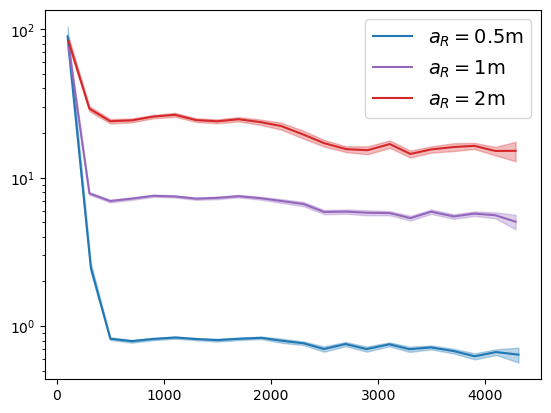

In [42]:
plt.plot(bins_05m, rate_05m_avg, label='$a_R=0.5$m', color='tab:blue')
plt.fill_between(bins_05m,[rate_05m_avg[i]-rate_05m_error[i] for i in range(len(rate_05m_avg))], \
                 [rate_05m_avg[i]+rate_05m_error[i] for i in range(len(rate_05m_avg))], color='tab:blue', alpha=0.3)
plt.plot(bins_1m, rate_1m_avg, label='$a_R=1$m', color='tab:purple')
plt.fill_between(bins_1m,[rate_1m_avg[i]-rate_1m_error[i] for i in range(len(rate_1m_avg))], \
                 [rate_1m_avg[i]+rate_1m_error[i] for i in range(len(rate_1m_avg))], color='tab:purple', alpha=0.3)
plt.plot(bins_2m, rate_2m_avg, label='$a_R=2$m', color='tab:red')
plt.fill_between(bins_2m,[rate_2m_avg[i]-rate_2m_error[i] for i in range(len(rate_2m_avg))], \
                 [rate_2m_avg[i]+rate_2m_error[i] for i in range(len(rate_2m_avg))], color='tab:red', alpha=0.3)
plt.yscale('log')
plt.legend(fontsize=14)
plt.savefig('/Users/yanxuan/Desktop/sup4.png',dpi=300,bbox_inches='tight')

## Figure S5 -- considering entanglement fidelity decrease (dephasing noise)

In [7]:
with open('./alice_bob_fiber_fidelity.csv', 'r') as csvfile:
    fiber_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]
# with open('./dephasing/alice_bob_fiber_fidelity_dephasing_10.csv', 'r') as csvfile:
#     fiber_fidelity_dephasing_10 = [float(item) for item in list(csv.reader(csvfile))[0]]
with open('./dephasing/alice_bob_fiber_fidelity_dephasing_5.csv', 'r') as csvfile:
    fiber_fidelity_dephasing_5 = [float(item) for item in list(csv.reader(csvfile))[0]]
with open('./dephasing/alice_bob_fiber_fidelity_dephasing_1.csv', 'r') as csvfile:
    fiber_fidelity_dephasing_1 = [float(item) for item in list(csv.reader(csvfile))[0]]
# len(fiber_fidelity_dephasing_5)

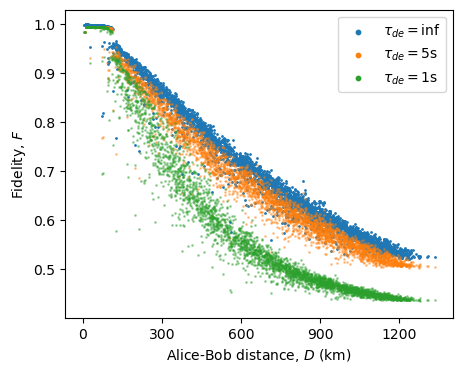

In [8]:
plt.figure(figsize=(5,4))
plt.scatter([Alice_bob_distances[i] for i in range(10000) if fiber_fidelity[i]>0], [item for item in fiber_fidelity if item>0], s=1)
# plt.scatter([Alice_bob_distances[i] for i in range(10000) if fiber_fidelity_dephasing_10[i]>0], [item for item in fiber_fidelity_dephasing_10 if item>0], color=[0.8500,0.3250,0.0980], s=1, alpha=0.4)
plt.scatter([Alice_bob_distances[i] for i in range(10000) if fiber_fidelity_dephasing_5[i]>0], [item for item in fiber_fidelity_dephasing_5 if item>0], s=1, alpha=0.4)
plt.scatter([Alice_bob_distances[i] for i in range(10000) if fiber_fidelity_dephasing_1[i]>0], [item for item in fiber_fidelity_dephasing_1 if item>0], s=1, alpha=0.4)
# plt.plot([0,1350], [0.87,0.87], color='tab:orange', linewidth=2)
plt.xticks([0,300,600,900,1200]); plt.ylim(0.4,1.03); plt.yticks([0.5,0.6,0.7,0.8,0.9,1])
plt.xlabel('Alice-Bob distance, $D$ (km)'); 
plt.ylabel('Fidelity, $F$')

plt.scatter(0,-1,color='tab:blue', s=10, label=r'$\tau_{de}=\inf$')
# plt.scatter(0,-1, color=[0.8500,0.3250,0.0980], s=10, label=r'$\tau_{de}=10$s')
plt.scatter(0,-1,color='tab:orange', s=10, label=r'$\tau_{de}=5$s')
plt.scatter(0,-1,color='tab:green', s=10, label=r'$\tau_{de}=1$s')
plt.legend()
plt.savefig('/Users/yanxuan/Desktop/S5.png', dpi=300, bbox_inches="tight")
plt.show()

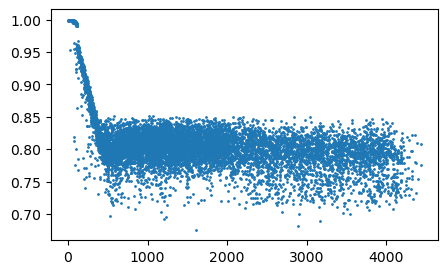

In [9]:
with open('./alice_bob_hybrid_fidelity_240.csv', 'r') as csvfile:
    hybrid_fidelity_240 = [float(item) for item in list(csv.reader(csvfile))[0]]
plt.figure(figsize=(5,3))
protocol_fidelity_240 = []
for i in range(10000):
    if hybrid_fidelity_240[i]>0:
        protocol_fidelity_240.append(max(fiber_fidelity[i],hybrid_fidelity_240[i]))
    else:
        protocol_fidelity_240.append(0)
plt.scatter([Alice_bob_distances[i] for i in range(10000) if protocol_fidelity_240[i]>0], [item for item in protocol_fidelity_240 if item>0.65], s=1)

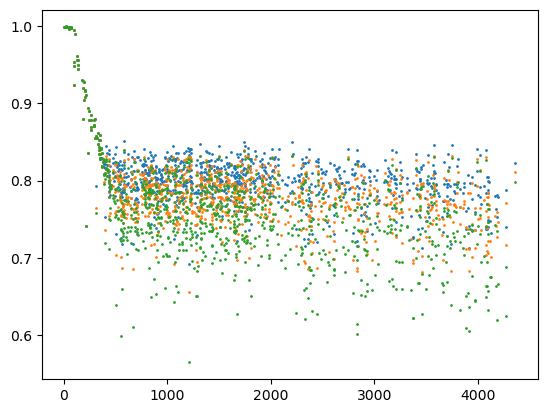

In [18]:
with open('./dephasing/hybrid_fidelity_5.csv', 'r') as csvfile:
    hybrid_fidelity_5 = [float(item) for item in list(csv.reader(csvfile))[0]]
protocol_fidelity_5 = [max(fiber_fidelity[i],hybrid_fidelity_5[i]) if hybrid_fidelity_5[i]>0 else 0 for i in range(1000)]
with open('./dephasing/hybrid_fidelity_1.csv', 'r') as csvfile:
    hybrid_fidelity_1 = [float(item) for item in list(csv.reader(csvfile))[0]]
protocol_fidelity_1 = [max(fiber_fidelity[i],hybrid_fidelity_1[i]) if hybrid_fidelity_1[i]>0 else 0 for i in range(1000)]
plt.scatter([Alice_bob_distances[i] for i in range(1000) if protocol_fidelity_240[i]>0], [item for item in protocol_fidelity_240[:1000] if item>0.65], s=1)
plt.scatter([Alice_bob_distances[i] for i in range(1000) if protocol_fidelity_5[i]>0], [item for item in protocol_fidelity_5 if item>0], s=1)
plt.scatter([Alice_bob_distances[i] for i in range(1000) if protocol_fidelity_1[i]>0], [item for item in protocol_fidelity_1 if item>0], s=1)

In [15]:
bin_size = 200;
bins_5s = [np.mean([aR_05_dis[i] for i in range(len(aR_05_rate)) if l<=aR_05_dis[i]<l+bin_size]) for l in range(0,4400,bin_size)]
rate_5s_avg = [np.mean([aR_05_rate[i] for i in range(len(aR_05_rate)) if l<=aR_05_dis[i]<l+bin_size]) for l in range(0,4400,bin_size)]
rate_5s_error = []
for l in range(0,4400,bin_size):
    test = [aR_05_rate[i] for i in range(len(aR_05_rate)) if l<=aR_05_dis[i]<l+bin_size]
    rate_05m_error.append(np.std(test)/np.sqrt(len(test)))

2000


## Figure S6 -- different satellite locations

In [51]:
with open('./alice_bob_fiber_rate.csv', 'r') as csvfile:
    fiber_rate = [float(item) for item in list(csv.reader(csvfile))[0]]
fiber_rate = [item if item>1e-6 else 0 for item in fiber_rate]
with open('./alice_bob_fiber_fidelity.csv', 'r') as csvfile:
    fiber_fidelity = [float(item) for item in list(csv.reader(csvfile))[0]]

In [89]:
south_most

24.5503525

In [139]:
sat_list = []; grid_south = 24.55
for i in np.arange(-123.6, -66, 1):
    if i==-79.6:
        lat_range = [item[1] for item in coors if i-0.1<item[0]<i+0.1 and item[1]>32]
        lat_min = min(lat_range); lat_max = max(lat_range)+0.2
        for j in np.arange(south_most, north_most+1, 1):
            if lat_min<=j<=lat_max:
                sat_list.append([i,j])
                # sat_list_long.append(i); sat_list_lat.append(j)
    
    elif i==-82.6:
        lat_range = [item[1] for item in coors if i-0.1<item[0]<i+0.1 and item[1]>26]
        lat_min = min(lat_range); lat_max = max(lat_range)+0.2
        for j in np.arange(south_most, north_most+1, 1):
            if lat_min<=j<=lat_max:
                sat_list.append([i,j])
                
    elif i==-80.6:
        # sat_list_long.extend([i,i,i,i]); sat_list_lat.extend([25.55,26.55,27.55,28.55])
        sat_list.extend([[i,25.55], [i,26.55], [i,27.55], [i,28.55]])
        lat_range = [item[1] for item in coors if i-0.1<item[0]<i+0.1 and item[1]>32]
        lat_min = min(lat_range); lat_max = max(lat_range)+0.2
        for j in np.arange(south_most, north_most+1, 1):
            if lat_min<=j<=lat_max:
                sat_list.append([i,j])
    elif i==-69.6:
        # sat_list_long.append(i); sat_list_lat.append(41.55)
        sat_list.append([i,41.55])
        lat_range = [item[1] for item in coors if i-0.1<item[0]<i+0.1 and item[1]>42]
        lat_min = min(lat_range); lat_max = max(lat_range)+0.2
        for j in np.arange(south_most, north_most+1, 1):
            if lat_min<=j<=lat_max:
                sat_list.append([i,j])
    else:
        lat_range = [item[1] for item in coors if i-0.5<item[0]<i+0.5]
        lat_min = min(lat_range); lat_max = max(lat_range)+0.2
        for j in np.arange(south_most, north_most+1, 1):
            if lat_min<=j<=lat_max:
                sat_list.append([i,j])
sat_list.extend([[-124.6,42.55], [-124.6,43.55], [-124.6,48.55], [-123.6,38.55], [-120.6,34.55], [-119.6,33.55], [-117.6,32.55], \
                 [-115.6,32.55], [-107.6,48.55], [-103.6,29.55],[-102.6,30.55],[-99.6,26.55], [-95.6,28.55], [-93.6,29.55], \
                 [-92.6,29.55], [-92.6,48.55], [-91.6,29.55], [-88.6,47.55], [-85.6,29.55], [-84.6,29.55], [-82.6,24.55], [-82.6,26.55], \
                 [-80.6,24.55], [-80.6,29.55], [-80.6,31.55], [-80.6,42.55], [-79.6,32.55], [-79.6,42.55], [-78.6,43.55], \
                 [-77.6,33.55], [-77.6,43.55], [-76.6,34.55],[-72.6,40.55],[-69.6,43.55], [-68.6,47.55]])

In [143]:
no_near_sat = []
for item in coors:
    nearby_sat = [sat for sat in sat_list if sat[0]-1/np.sqrt(2)<item[0]<sat[0]+1/np.sqrt(2) or sat[1]-1/np.sqrt(2)<item[1]<sat[1]+1/np.sqrt(2)]
    if min([(item[0]-sat[0])**2+(item[1]-sat[1])**2 for sat in nearby_sat])>1/2:
        no_near_sat.append(item)

(-127.44999999999999, -64.75, 23.349982375, 49.750370125)

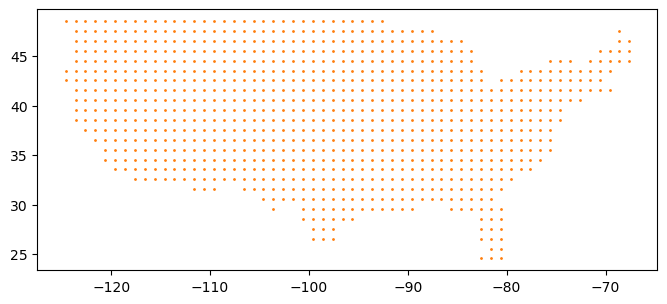

In [145]:
plt.figure(figsize=(8,5)); plt.scatter([item[0] for item in no_near_sat], [item[1] for item in no_near_sat], s=1)
plt.scatter([item[0] for item in sat_list],[item[1] for item in sat_list], s=1); plt.axis('scaled')

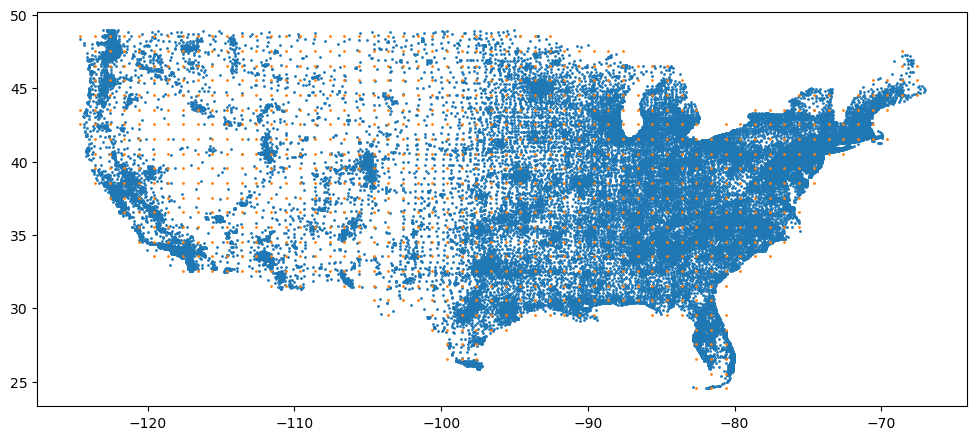

In [147]:
plt.figure(figsize=(12,6)); 
plt.scatter([item[0] for item in coors],[item[1] for item in coors],s=1)
plt.scatter([item[0] for item in sat_list],[item[1] for item in sat_list], s=1); plt.axis('scaled')
plt.savefig('/Users/yanxuan/Desktop/s6-1.png', dpi=300, bbox_inches='tight')

In [148]:
sat_rate_lower = []; sat_rate_upper = []
for [alice, bob] in Alice_bob_pairs:
    sat_rate_list = [6e7*satellite_station_loss([sat_list_long[i],sat_list_lat[i]], coors[alice])*\
                     satellite_station_loss([sat_list_long[i],sat_list_lat[i]], coors[bob]) for i in range(len(sat_list_long))]
    sat_rate_lower.append(min(sat_rate_list)); sat_rate_upper.append(max(sat_rate_list))

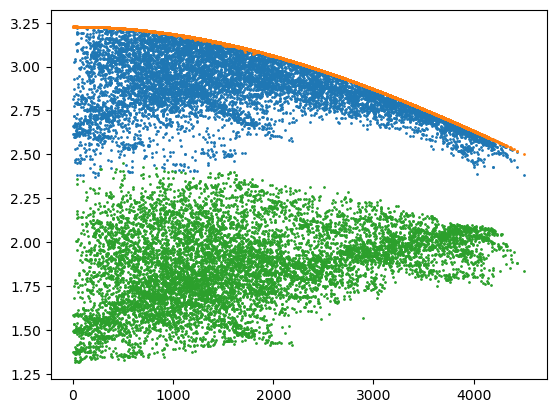

In [149]:
plt.scatter(Alice_bob_distances, sat_rate, s=1)
plt.scatter(Alice_bob_distances, sat_rate_upper, s=1)
plt.scatter(Alice_bob_distances, sat_rate_lower, s=1)
# plt.yscale('log'); plt.ylim(1e-6,1e3); plt.xlim(0,2500)

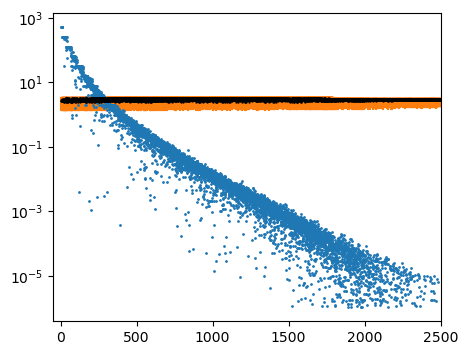

In [176]:
plt.figure(figsize=(5,4))
plt.scatter([Alice_bob_distances[i] for i in range(10000) if fiber_rate[i]>1e-6], [item for item in fiber_rate if item>1e-6], s=1, zorder=1, color='tab:blue'); 
plt.scatter(Alice_bob_distances, sat_rate, s=0.5, zorder=2, color='black', label='Centered satellite')
for i in range(10000):
    plt.plot([Alice_bob_distances[i],Alice_bob_distances[i]], [sat_rate_lower[i],sat_rate_upper[i]], color='tab:orange',zorder=0)

plt.yscale('log'); plt.xlim(-50,2500)
# plt.xlabel('Alice-Bob distance, $D$ (km)'); plt.ylabel('Distribution rate, $R$ ($s^{-1}$)')
plt.savefig('/Users/yanxuan/Desktop/s6-2.png', dpi=300, bbox_inches='tight')

In [153]:
# with open('./sat_loc/sat_rate_lower.csv', 'w') as csvfile:
#     csv.writer(csvfile).writerow(sat_rate_lower)
# with open('./sat_loc/sat_rate_upper.csv', 'w') as csvfile:
#     csv.writer(csvfile).writerow(sat_rate_upper)

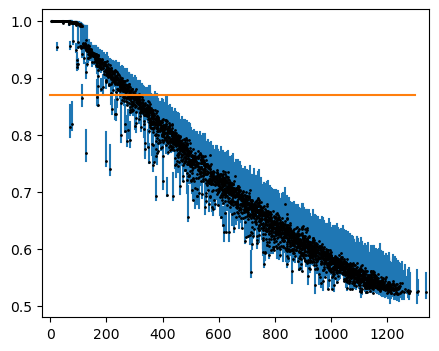

In [179]:
with open('./sat_loc/fiber_fidelity_lower.csv', 'r') as csvfile:
    fiber_fidelity_lower = [float(item) for item in list(csv.reader(csvfile))[0]]
with open('./sat_loc/fiber_fidelity_upper.csv', 'r') as csvfile:
    fiber_fidelity_upper = [float(item) for item in list(csv.reader(csvfile))[0]]

plt.figure(figsize=(5,4))
for i in range(10000):
    if fiber_fidelity[i]>0 and fiber_fidelity_lower[i]>0 and fiber_fidelity_upper[i]>0:
        plt.plot([Alice_bob_distances[i],Alice_bob_distances[i]], [fiber_fidelity_lower[i],fiber_fidelity_upper[i]], color='tab:blue',zorder=0)
plt.scatter([Alice_bob_distances[i] for i in range(10000) if fiber_fidelity_lower[i]>0 and fiber_fidelity_upper[i]>0],\
            [fiber_fidelity[i] for i in range(10000) if fiber_fidelity_lower[i]>0 and fiber_fidelity_upper[i]>0], s=1, zorder=1, color='black')
plt.ylim(0.48,1.02); plt.xlim(-30,1350)
plt.plot([0,1300],[0.87,0.87],color='tab:orange')
plt.savefig('/Users/yanxuan/Desktop/s6-3.png', dpi=300, bbox_inches='tight')

0.09580827212843929


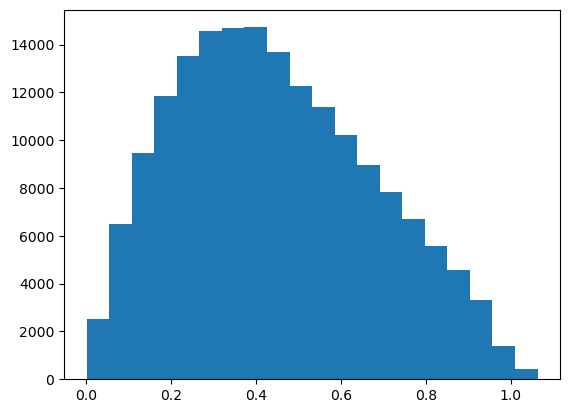

In [37]:
# distribution of zenith angle
def zenith_angle(sat, sta):
    lat = sta[1]/180*np.pi
    long = sta[0]/180*np.pi
    sat_lat = sat[1]/180*np.pi
    sat_long = sat[0]/180*np.pi
    z = np.sqrt(((h+r)*np.cos(sat_lat)*np.cos(sat_long)-r*np.cos(lat)*np.cos(long))**2 + \
                ((h+r)*np.cos(sat_lat)*np.sin(sat_long)-r*np.cos(lat)*np.sin(long))**2 + \
                ((h+r)*np.sin(sat_lat)-r*np.sin(lat))**2)
    cos_theta = (h**2-z**2+2*h*r)/(2*z*r)
    return np.arccos(cos_theta)

alice = Alice_bob_pairs[0][0]
sat = [sat_list_long[0],sat_list_lat[0]]
print(zenith_angle(sat,coors[alice]))
zenith_angle_list = []
for [alice, bob] in Alice_bob_pairs[:100]:
    zenith_angle_list.extend([zenith_angle([sat_list_long[i],sat_list_lat[i]], coors[alice]) for i in range(len(sat_list_long))])
    zenith_angle_list.extend([zenith_angle([sat_list_long[i],sat_list_lat[i]], coors[bob]) for i in range(len(sat_list_long))])
plt.hist(zenith_angle_list, bins=20); plt.show()

In [40]:
# with open('./sat_loc/sat_rate_lower.csv', 'w') as csvfile:
#     csv.writer(csvfile).writerow(sat_rate_lower)
# with open('./sat_loc/sat_rate_upper.csv', 'w') as csvfile:
#     csv.writer(csvfile).writerow(sat_rate_upper)

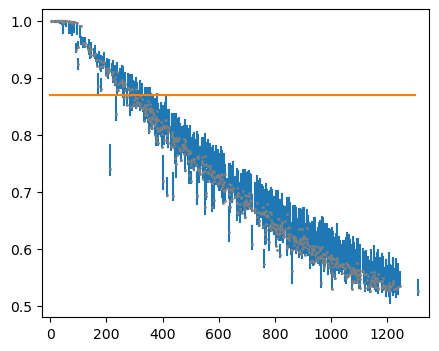

In [77]:
with open('./sat_loc/fiber_fidelity_lower_0.csv', 'r') as csvfile:
    fiber_fidelity_lower = [float(item) for item in list(csv.reader(csvfile))[0]]
with open('./sat_loc/fiber_fidelity_upper.csv', 'r') as csvfile:
    fiber_fidelity_upper = [float(item) for item in list(csv.reader(csvfile))[0]]

plt.figure(figsize=(5,4))
for i in range(2000):
    if fiber_fidelity[i]>0 and fiber_fidelity_lower[i]>0 and fiber_fidelity_upper[i]>0:
        plt.plot([Alice_bob_distances[i],Alice_bob_distances[i]], [fiber_fidelity_lower[i],fiber_fidelity_upper[i]], color='tab:blue',zorder=0)
plt.scatter(Alice_bob_distances[:2000], fiber_fidelity[:2000], s=1, zorder=1, color='gray')
plt.ylim(0.48,1.02); plt.xlim(-30,1350)
plt.plot([0,1300],[0.87,0.87],color='tab:orange')
plt.savefig('/Users/yanxuan/Desktop/s6-3.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.scatter(range(10000), [1 for i in range(10000)], s=1)
plt.scatter(range(10000), [sat_rate_upper[i]/sat_rate[i] for i in range(10000)], s=1)
plt.scatter(range(10000), [sat_rate_lower[i]/sat_rate[i] for i in range(10000)], s=1)

## mixed state purification

In [2]:
def purify_2_1(p1, p2):
    prob = (1+p1*p2)/2
    new_p = (p1+p2+4*p1*p2)/(3+3*p1*p2)
    return new_p, prob
def F_value(p):
    return (3*p+1)/4
def p_value(F):
    return (4*F-1)/3
    
def purification(p_list):
    while len(p_list)>1:
        p_list.sort(reverse=True)
        p1 = p_list[-1]; p_list.pop(-1)
        p2 = p_list[-1]; p_list.pop(-1)
        new_p, prob = purify_2_1(p1,p2)
        if np.random.random()<prob:
            p_list.append(new_p)
    # return max(p_list)
    if len(p_list)>0:
        return max(p_list)
    else:
        return p_value(F0)

In [10]:
F0 = 0.99; purified_F = []
V = 2*0.99-1; F0 = 1/2*(1+V*(1-2*F0)**2); 
for n in range(3,100):
    purified_f = [purification([F0 for i in range(n-1)]) for j in range(1000)]
    purified_F.append(np.mean(purified_f))

In [136]:
F0 = 0.99; 
V = 2*0.99-1; F0 = 1/2*(1+V*(1-2*F0)**2); 
Puri = []
for i in range(0,100000):
    Puri.append(F_value(purification([p_value(F0) for i in range(2)])))
np.mean(Puri)

0.9794604386375647

./fiber_matlab/purified_F_final is the correct one

In [8]:
with open('./purified_F_final.csv', 'r') as csvfile:
    purified_F_file = [float(item) for item in list(csv.reader(csvfile))[0]]

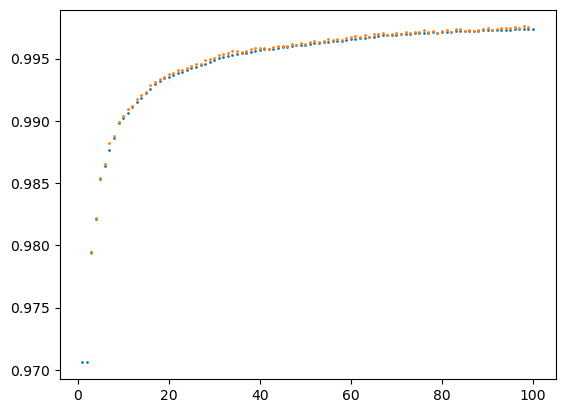

In [11]:
plt.scatter(range(1,101), purified_F_file[:100],s=1)
plt.scatter(range(3,100), purified_F,s=1)

In [4]:
with open('./purified_F_final_099.csv', 'r') as csvfile:
    purified_F_099 = [float(item) for item in list(csv.reader(csvfile))[0]]

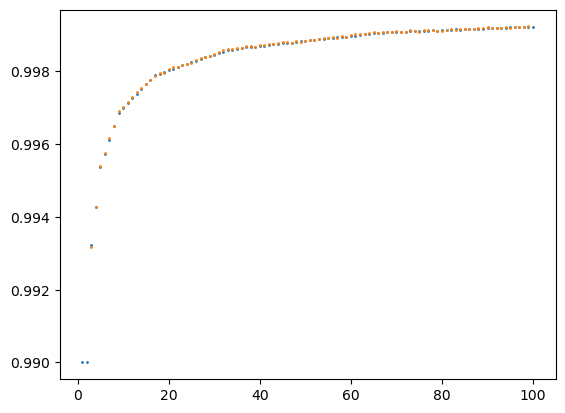

In [5]:
plt.scatter(range(1,101), purified_F_099[:100],s=1)
plt.scatter(range(3,100), purified_F,s=1)

## how to deal with the (3/2)^nu coefficient for cases with purification

In [18]:
# nu=1, np=2
eta = 0.1; 
Total_step = []
for iter in range(10000):
    success1 = 0; success2 = 0; total_step = 0
    while success1==0 or success2==0:
        total_step+=1
        if np.random.random()<eta:
            success1=1
        if np.random.random()<eta:
            success2=1
    Total_step.append(total_step)
print(np.mean(Total_step))

14.7847
